In [1]:
import numpy as np

# The only function that the user has to interact with. member is the initial membership
# array, X is the observed data set, alpha is the exponent used on the Euclidean distance.
def e_agglo(X, member = None, alpha = 1, penalty = lambda cps : 0):
    if member is None:
        member = np.arange(X.shape[0])
    if (alpha <= 0) or (alpha > 2):
        raise ValueError("The alpha argument must be in (0, 2].")
    if(not callable(penalty)):
        raise ValueError("The penalty argument must be a function.")
    ret = process_data(member, X, alpha)
    n = ret["n"]

    #Find which clusters optimize the GOF and then update distances
    for k in range(n-1+1, 2*n-2+1):
        #find which clusters to merge
        best = find_closest(k, ret) 
        #update GOF statistic
        ret["fit"].append(best[2])

        #Update information after merge
        ret = update_distance(best[0], best[1], k, ret)
    
    # Penalize the GOF statistic
    cps = [x[~np.isnan(x)] for x in np.array(ret["progression"].tolist())]
    ret["fit"] = np.trim_zeros(ret["fit"] + list(map(penalty, cps)))
    # Get the set of change points for the "best" clustering
    ret["estimates"] = np.argmax(ret["fit"])
    ret["estimates"] = np.sort(ret["progression"][ret["estimates"]])
    ret["estimates"] = ret["estimates"][~np.isnan(ret["estimates"])].astype(int)
    
    #Fix the Python 0-indexing.
    ret["estimates"] = ret["estimates"] - 1
    ret["progression"] = ret["progression"] - 1

    # Remove change point N + 1 if a cyclic merger was performed
    if(ret["estimates"][0] != 0):
        ret["estimates"] = ret["estimates"][:-1]
    
    # Create final membership vector
    tmp = ret["estimates"]
    if (tmp[0] == 0):
        ret["cluster"] = np.repeat(np.arange(0,len(np.diff(tmp))), np.diff(tmp))
    else:
        tmp = np.insert(tmp, 0, 0)

        ret["cluster"] = np.repeat(np.arange(0,len(np.diff(tmp))), np.diff(tmp))
        k = X.shape[0] - np.size(ret["cluster"])
        ret["cluster"] = np.append(ret["cluster"], np.zeros(k, dtype = int))
    
    # Remove unnecessary output info
    rem = ["n", "left", "open", "d", "right", "lm", "sizes"]
    for each in rem:
        ret.pop(each, None)
    return ret

#Initialize all the necessary components of the dictionary.
def process_data(member, X, alpha):
    ret = {} #the dictionary with the necessary information
    u = np.unique(member)
    ret["n"] = u.size #number of clusters
    n = ret["n"]
    fit = 0

    #relabel clusters
    for i in range(n): 
        member[member == u[i]] = i

    #Check that segments conssit only of adjacent observations
    if(not np.all(member[:-1] <= member[1:])):
        raise ValueError("Segments must be contiguous.")
    
    ret["sizes"] = np.zeros(2*n, dtype = int)

    #Left and Right neighbors of a cluster
    ret["right"] = np.zeros(2*n - 1, dtype = int)
    ret["left"] = np.zeros(2*n - 1, dtype = int)

    #True means that a cluster has not been merged
    ret["open"] = np.ones(2*n - 1, dtype = bool)

    #Calculate initial cluster sizes
    for i in range(n):
        ret["sizes"][i] = np.sum(member==i)
    #Set up left and right neighbors
    for i in range(1, n-1):
        ret["left"][i] = i - 1
        ret["right"][i] = i + 1

    #Special case for clusters 1 and N to allow for cyclic merging
    ret["left"][n-1] = n - 2
    ret["right"][n] = 0
    ret["left"][0] = n - 1
    ret["right"][0] = 1

    #Matrix to say which clusters were merged at each step
    ret["merged"] = np.full((n-1, 2), np.nan)

    #Array of within distances
    within = np.zeros(n)
    for i in range(n):
        within[i] = get_within(alpha, np.full((ret["sizes"][i], X.shape[1]), X[member == i]))
    
    #Make distance matrix
    ret["d"] = np.full((2*n, 2*n), np.float("inf"))
    for i in range(n):
        for j in range(i, n):
            if (j != i): 
                gb = get_between(alpha,
                    np.full((ret["sizes"][i], X.shape[1]), X[member==i]),
                    np.full((ret["sizes"][j], X.shape[1]), X[member==j])) - within[i] - within[j]
                ret["d"][i, j] = gb
                ret["d"][j, i] = gb
    np.fill_diagonal(ret["d"], 0.0)

    #Set initial GOF value
    for i in range(n):
        fit = fit + ret["d"][i, ret["left"][i]] + ret["d"][i, ret["right"][i]]
    ret["fit"] = [fit]

    #Create matrix for change point progressoin
    ret["progression"] = np.full((n, n+1), np.nan)
    ret["progression"][0, 0] = 1
    for i in range(1, n + 1):
        ret["progression"][0, i] = ret["progression"][0, i - 1] + ret["sizes"][i-1]
    
    #Vector to specify the starting point of a cluster
    ret["lm"] = np.zeros(2*n-1, dtype = int)
    ret["lm"][:n] = np.arange(n)
    return ret

# Determine which clusters will be merged. Returns a tuple of length 3: the first
# element is the left cluster, the second is the right, and the third is the newest
# GOF value.
def find_closest(k, ret):
    n = ret["n"]
    best = float('-inf')
    triple = (0, 0, 0)
    
    #iterate to see how the GOF value changes
    for i in range(k):
        if (ret["open"][i]):

            #Get updated GOF value
            x = gof_update(i, ret)
            #Better value found so update
            if (x > best):
                best = x
                triple = (i, ret["right"][i], x)
    if (not triple[0] and not triple[1] and k !=(2*n - 2)):
        raise ValueError("There was a problem finding which clusters to merge.")
    return triple

# Function to calculate the new GOF value. The i argument is assumed to be the 
# left cluster.
def gof_update(i, ret):
    fit = ret["fit"][-1]
    j = ret["right"][i]

    #Get new left and right clusters
    rr = ret["right"][j]
    ll = ret["left"][i]
    #Remove unneded values in the GOF
    fit = fit - 2*(ret["d"][i, j] + ret["d"][i, ll] + ret["d"][j, rr])
    #Get cluster sizes
    n1 = ret["sizes"][i]
    n2 = ret["sizes"][j]

    #Add distance to new left cluster
    n3 = ret["sizes"][ll]
    k = ((n1 + n3)*ret["d"][i, ll] + (n2 + n3)*ret["d"][j, ll] - n3 * ret["d"][i, j])/(n1 + n2 + n3)
    fit = fit + 2 *k

    #Add distance to new right cluster
    n3 = ret["sizes"][rr]
    k = ((n1+n3)*ret["d"][i, rr] + (n2+n3)*ret["d"][j, rr] - n3*ret["d"][i, j])/(n1+n2+n3)
    fit = fit + 2*k

    return fit

# Function to update the distance from the new cluster to the other clusters.
# i is assumed to be the left cluster. Also #updates any other necessary 
# information in [ret].
def update_distance(i, j, k, ret):
    k -=1
    n = ret["n"]
    # Say which clusters were merged
    if (i <= n):
        ret["merged"][k - n + 1, 0] = -i
    else:
        ret["merged"][k - n + 1, 0] = i - n
    if (j <= n):
        ret["merged"][k - n + 1, 1] = -j
    else:
        ret["merged"][k - n + 1, 1] = j - n
    
    # Update left and right neighbors
    ll = ret["left"][i]
    rr = ret["right"][j]
    ret["left"][k + 1] = ll
    ret["right"][k + 1] = rr
    ret["right"][ll] = k + 1
    ret["left"][rr] = k + 1

    # Update information on which clusters have been merged
    ret["open"][i] = False
    ret["open"][j] = False

    #Assign size to newly created cluster
    n1 = ret["sizes"][i]
    n2 = ret["sizes"][j]
    ret["sizes"][k + 1] = n1 + n2

    #Update set of change points
    ret["progression"][k-n+2] = ret["progression"][k-n+1]
    ret["progression"][k-n+2, ret["lm"][j]] = np.nan
    ret["lm"][k+1] = ret["lm"][i]

    
    #Update distances
    for kk in range(k+1):
        if (ret["open"][kk]):
            n3 = ret["sizes"][kk]
            nn = n1+n2+n3
            hold = ((nn-n2)*ret["d"][i, kk] + (nn-n1)*ret["d"][j, kk] - n3*ret["d"][i, j])/nn
            ret["d"][k+1, kk] = hold
            ret["d"][kk, k+1] = hold

    return ret

#Consider using: scipy.stats.energy_distance
def get_within(alpha, X):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]

    #Slow C version
    # for i in range(n):
    #     for j in range(n):
    #         ret += np.power(np.sqrt(np.sum((X[i, :] - X[j, :])*(X[i, :] - X[j, :]))), alpha)
    # return (ret/(n*n))

    #Vectorized:
    Xprime = X.reshape(n, 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Xprime, X-Xprime)), alpha))
    return ret/(n*n)

def get_between(alpha, X, Y):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]
    m = Y.shape[0]

    #Slow C version
    # for i in range(n):
    #     for j in range(m):
    #         ret += np.power(np.sqrt(np.sum(np.power(X[i]-Y[j], 2))), alpha)
    
    #Vectorized:
    X = X.reshape(X.shape[0], 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Y, X-Y)), alpha))
    return (2*ret)/float(n*m)

In [2]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
from ecp import e_divisive, e_agglomerative
%matplotlib inline

In [170]:
def mkv_to_ts(P, S, sigma = 1, n = 10000, debug=False):
    k = len(S)
    base_matrix = np.tile(S, (n, 1)).T
    noise_matrix = np.random.normal(0, sigma, (k, n))
    full_matrix = base_matrix + noise_matrix
    
    state_gen = np.empty(n, dtype = np.int32)
    state_gen[0] = 0
    for i in range(1, n):
        state_gen[i] = np.random.choice(k, p=P[state_gen[i-1]])
    return state_gen if debug else np.choose(state_gen, full_matrix)

Estimated Number of Change Points: 30.0
Minimum Size before Change: 2
Time:  2.1204891204833984
Found Change Points: 30


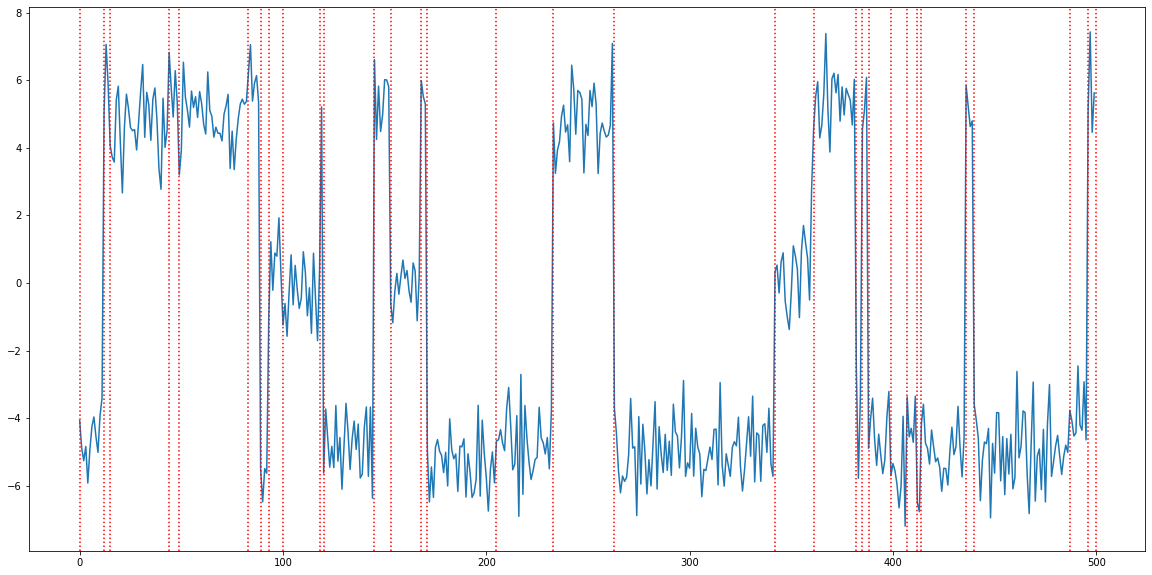

In [191]:
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
S = np.array([-5, 0, 5])

N = 500
K = int(N/(1/(1 - P[0, 0]))) + N/100
ms = 2
num_of_states = len(S)

ts = mkv_to_ts(P, S, n=N)
plt.figure(figsize=(20,10))
plt.plot(ts)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
# sol_dict = e_agglomerative.e_agglo(X = np.reshape(ts, (len(ts), 1)), alpha=2, penalty=lambda x : -500)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

In [192]:
def get_within(alpha, X):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]

    Xprime = X.reshape(n, 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Xprime, X-Xprime)), alpha))
    return ret/(n*n)

def get_between(alpha, X, Y):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]
    m = Y.shape[0]

    X = X.reshape(X.shape[0], 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Y, X-Y)), alpha))
    return (2*ret)/float(n*m)



# alpha = alpha
# ts = ts
# n = len(sol_dict['estimates'])-1
# cluster = sol_dict['cluster']
# k = stopping condition (num_of_states)
def agglo_method(alpha, n, ts, cluster, k):
    ret = {"order": [], "cluster": cluster}
    curr_n = n
    if curr_n <= k:
        return ret
    
    within = np.zeros(n)
    for i in range(n):
        working_ts = ts[cluster==i]
        within[i] = get_within(alpha, np.reshape(working_ts, (len(working_ts), 1)))

    dflat = np.zeros(int(((n*n)-n)/2))
    idx = 0
    md = [] #maps from the linear index to the tuple (i, j) in the non-flattened distance matrix

    for i in range(n):
        for j in range(i+1, n):
            working_ts1 = ts[cluster==i]
            working_ts2 = ts[cluster==j]
            d = get_between(alpha, np.reshape(working_ts1, (len(working_ts1), 1)), np.reshape(working_ts2, (len(working_ts2), 1))) - within[i] - within[j]
            dflat[idx] = d
            idx += 1
            md.append((i, j))
    while(curr_n > k):
        min_idx = np.nanargmin(dflat)
        i, j = md[min_idx]
        ret["order"].append((i, j))
        
        
        cluster[cluster==j] = i
        working_ts = ts[cluster == i]
        new_within = get_within(alpha, np.reshape(working_ts, (len(working_ts), 1)))
        within[i] = new_within
        within[j] = new_within
        
        for idx in range(n):
            if idx != j and idx != i:
                working_ts1 = ts[cluster==i]
                working_ts2 = ts[cluster==idx]
                d = get_between(alpha, np.reshape(working_ts1, (len(working_ts1), 1)), np.reshape(working_ts2, (len(working_ts2), 1))) - within[i] - within[idx]
                
                if idx < i:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*i) - (3*idx) - 2)/2)
                    dflat[flat_idx] = d
                elif idx > i:
                    flat_idx = int(((2*i*n) - (i*i) + (2*idx) - (3*i) - 2)/2)
                    dflat[flat_idx] = d
                    
                if idx < j:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*j) - (3*idx) - 2)/2)
                    dflat[flat_idx] = np.inf
                elif idx > j:
                    flat_idx = int(((2*j*n) - (j*j) + (2*idx) - (3*j) - 2)/2)
                    dflat[flat_idx] = np.inf
            elif idx == j:
                t1, t2 = (i, j) if i < j else (j, i)
                flat_idx = int(((2*t1*n) - (t1*t1) + (2*t2) - (3*t1) - 2)/2)
                dflat[flat_idx] = np.inf  
                
                flat_idx = int(((2*t2*n) - (t2*t2) + (2*t1) - (3*t2) - 2)/2)
                dflat[flat_idx] = np.inf
        curr_n = len(np.unique(cluster))
    ret["cluster"] = cluster
    print(ret)
    
    return ret
    

# print(dflat)

In [1]:
cluster_labels = agglo_method(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=3)["cluster"]

NameError: name 'agglo_method' is not defined

In [194]:
new_ests = [sol_dict['estimates'][0]]
for i in range(1, len(cluster_labels)):
    if cluster_labels[i] != cluster_labels[i-1]:
        new_ests.append(i)
new_ests.append(sol_dict['estimates'][-1])

[0, 12, 89, 93, 118, 120, 145, 153, 168, 171, 233, 263, 342, 361, 382, 385, 388, 436, 440, 496, 500]


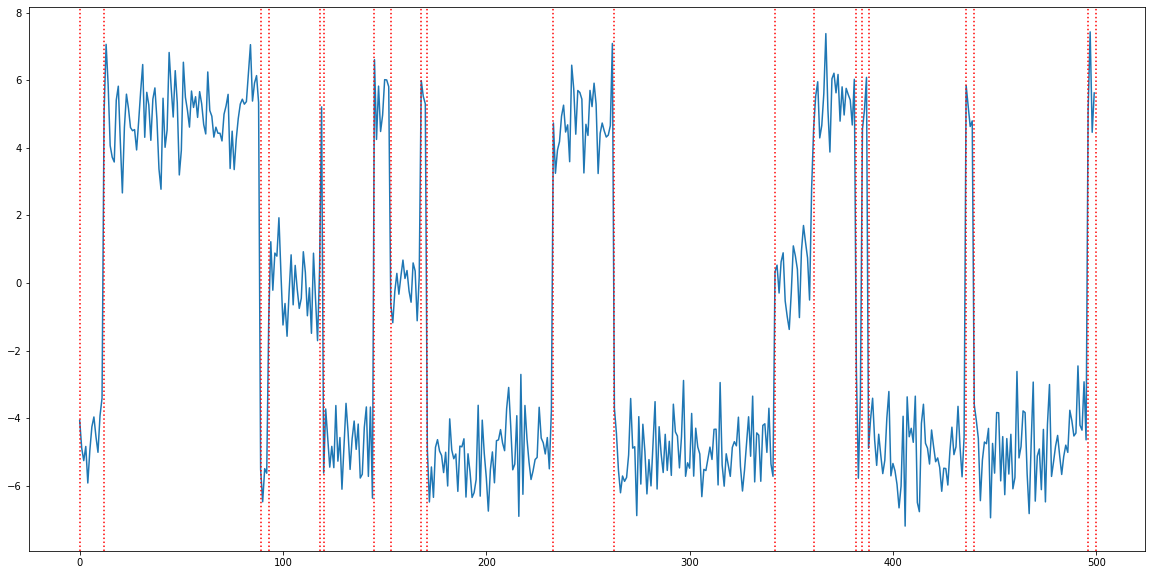

In [195]:
print(new_ests)
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in new_ests:
    plt.axvline(x=xc, color='r', linestyle=':')